In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '237179',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/E8qBDKe39KEFMo-LhTNDQQ__thumb/img/jFQaWbcjoUzxS7p76LsGzg4piQk=/fit-in/200x150/filters:strip_icc()/pic6333980.jpg',
  'name': 'Weather Machine',
  'yearpublished': '2022'},
 {'id': '322708',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/Q96PxRVbrDxS9_4ZPTJtHQ__thumb/img/hXnjkvD7KiLk2fon8tbvsXNtT_k=/fit-in/200x150/filters:strip_icc()/pic5941333.png',
  'name': 'Descent: Legends of the Dark',
  'yearpublished': '2021'}]

In [6]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

reading dataframe from csv file...


,id,username,rating,value
0,237179,astronaut70,8.0,Rating based on expectation - will adjust when...
1,237179,atcblake,N/A,"Solo, engine builder?"
2,237179,Beer4Dad,8.0,*Rating based on multiple advanced stage proto...
3,237179,BlueFoxMoon,N/A,Pre-release - KS Vital Lacerda
4,237179,Carter_Burke,N/A,Lacerda Game. Must-buy but Start saving... :-)
...,...,...,...,...
110787,167791,z_zadar,9.0,Some games are so much fun. Others can be a li...
110788,167791,_Czid_,8.0,Have played with Elysium and Prelude expansion...
110789,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
110790,167791,_mun_,10.0,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [7]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [8]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 18020 for 'remove_short_comments' - min len: 25 - method: unrated


In [9]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [10]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

9.0        17365
10.0       16997
8.0        15427
7.0         8229
N/A         7434
           ...  
2.73           1
9.245          1
2.4            1
8.43312        1
8.26667        1
Name: rating, Length: 591, dtype: int64

In [11]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(85338, 5)

In [12]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(7434, 5)

## CREATE TRAINING AND VALIDATION DATA

In [13]:
# use rated comments (reviews) to train the model

In [14]:
rated_comments = rated_comments.sample(frac=1)

In [15]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [16]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'Excellent game where you gather resources in order to play bird cards in your "aviary."  Those birds give you points and usually have helpful powers that make your turns better in the future.  Once you get past the unusual theme, it\'s a game that appeals to a wide audience.'

In [17]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'average of over 9 - irreasonable ratings of fans here which make the entire rating system ridiculous. What if there were 5 more versions of Gloomhaven? will this become gloomhavengeek.com? Therefore only 1 star cause of this hilarious hype.'

## COMPOSE MODEL

In [18]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [19]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
42/42 - 11s - loss: 0.5422 - accuracy: 0.8162 - val_loss: 0.4706 - val_accuracy: 0.8484
Epoch 2/100
42/42 - 9s - loss: 0.4108 - accuracy: 0.8525 - val_loss: 0.3858 - val_accuracy: 0.8494
Epoch 3/100
42/42 - 9s - loss: 0.3362 - accuracy: 0.8586 - val_loss: 0.3488 - val_accuracy: 0.8587
Epoch 4/100
42/42 - 9s - loss: 0.2933 - accuracy: 0.8783 - val_loss: 0.3305 - val_accuracy: 0.8696
Epoch 5/100
42/42 - 9s - loss: 0.2627 - accuracy: 0.8943 - val_loss: 0.3232 - val_accuracy: 0.8745
Epoch 6/100
42/42 - 9s - loss: 0.2373 - accuracy: 0.9057 - val_loss: 0.3244 - val_accuracy: 0.8752
Epoch 7/100
42/42 - 9s - loss: 0.2152 - accuracy: 0.9158 - val_loss: 0.3268 - val_accuracy: 0.8716
Epoch 8/100
42/42 - 9s - loss: 0.1956 - accuracy: 0.9247 - val_loss: 0.3367 - val_accuracy: 0.8708
Epoch 9/100
42/42 - 9s - loss: 0.1787 - accuracy: 0.9323 - val_loss: 0.3473 - val_accuracy: 0.8666
Epoch 10/100
42/42 - 9s - loss: 0.1646 - accuracy: 0.9388 - val_loss: 0.3635 - val_accuracy: 0.8654
28/28 - 

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000022A90CF13A0>,
             param_grid={})

In [20]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [21]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [23]:
epochs = range(1, len(acc) + 1) 

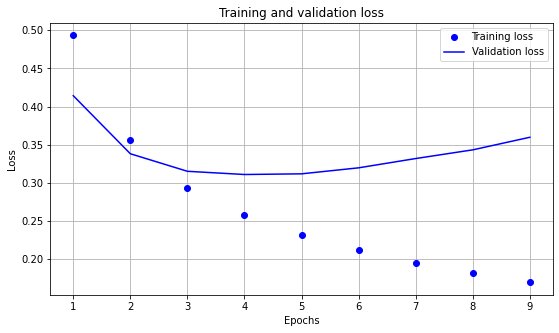

In [24]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

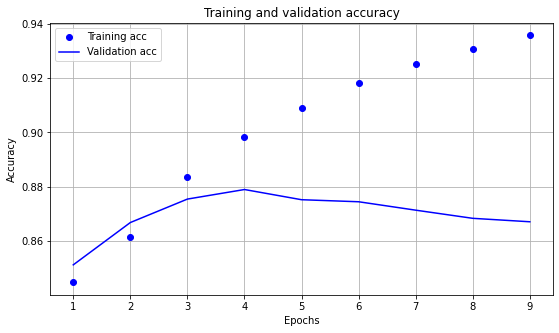

In [25]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [26]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"Excellent game where you gather resources in order to play bird cards in your "aviary."  Those birds give you points and usually have helpful powers that make your turns better in the future.  Once you get past the unusual theme, it's a game that appeals to a wide audience."
score: 1.000000
actual: 1

input:
"Play weekly with friend after playing gloomhaven"
score: 1.000000
actual: 1

input:
"Eurogame are a bit boring to me because of their lack of theme. However this game has very solid mechanics and easy to learn rules while leaving place for strategies and complexity. Very well designed. It would be even better with more interaction between players. It felt like everybody was playing almost alone, maybe because we were beginners?"
score: 0.000000
actual: 1

input:
"Ordered this on. board game Lisa for 44$ cad…..a real steal. Super good game. I would prefer this than Maracaibo due to its western theme.  City Slickers anyone?"
score: 1.000000
actual: 1

input:
"This game is so

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
## APPLY MODEL ON NON-RATED COMMENTS

In [28]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

8/8 - 0s
input:
"Nice villain versus game.  A deck builder with out the randomisation of dc deck builder or legendary.  I prefer it.  Great art."
score: 1.000000

input:
"Have played the first couple scenarios. Really dug it. Waiting to get deeper into it before reviewing."
score: 1.000000

input:
"Worried this is too heavy but Wingspan by same publisher is so great and this version of Viticulture comes with an Automa and I love that aspect of Wingspan so I'm really thinking about it.  Need to study up some more on Viticulture. Be sure to get the Essential Edition for the Automa."
score: 1.000000

input:
"Includes Invaders from Afar and wooden insert"
score: 1.000000

input:
"Ve hře Blood Rage se 2 – 4 hráči (s rozšířením maximálně 5) utkávají v nelítostném krvavém boji o slávu. Během tří věků (kol) budou vylepšovat svůj klan a snažit se nasbírat co nejvíce vítězných bodů, které se získávají primárně bojem. Výhra v mohutné bitvě na život a na smrt udělá na bohy dojem. Ale i ti, kteří s

## REGRESSOR

In [29]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000022F6C6038B0>,
             param_grid={})

In [30]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [31]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [32]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [33]:
epochs = range(1, len(mean_squared_error) + 1) 

In [34]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.40


In [35]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 0.93


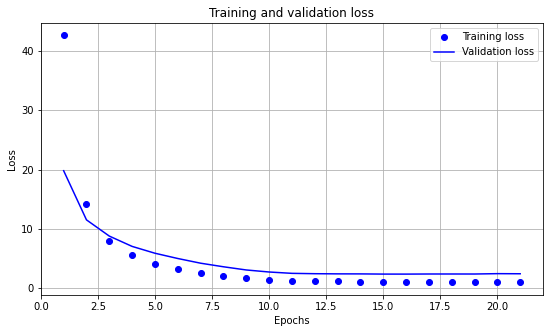

In [36]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

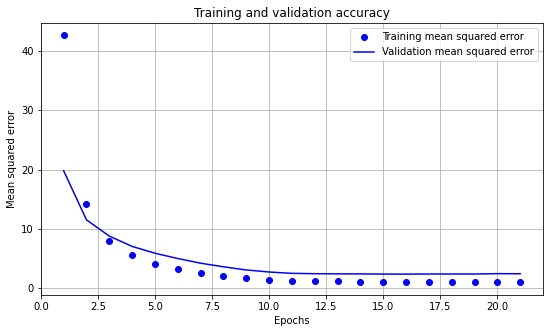

In [37]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [38]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"Excellent game where you gather resources in order to play bird cards in your "aviary."  Those birds give you points and usually have helpful powers that make your turns better in the future.  Once you get past the unusual theme, it's a game that appeals to a wide audience."
score: 8.36
actual: 9.00 

input: 
"Play weekly with friend after playing gloomhaven"
score: 9.41
actual: 10.00 

input: 
"Eurogame are a bit boring to me because of their lack of theme. However this game has very solid mechanics and easy to learn rules while leaving place for strategies and complexity. Very well designed. It would be even better with more interaction between players. It felt like everybody was playing almost alone, maybe because we were beginners?"
score: 5.99
actual: 7.00 

input: 
"Ordered this on. board game Lisa for 44$ cad…..a real steal. Super good game. I would prefer this than Maracaibo due to its western theme.  City Slickers anyone?"
score: 8.07
actual: 8.00 

input: 
"This game

## COMPARE CLASSIFIER VS REGRESSOR

In [39]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"waiting for edition with acceptable component quality"
    reg score: 7.85
    clf score: 1

"might not be the top choice for 2 players"
    reg score: 7.51
    clf score: 0

"With The Riverfolk, Clockwork, and Underworld Expansions."
    reg score: 9.42
    clf score: 1

"SCYTHE  RENT FOR 1 WEEK - 500PHP SECURITY DEPOSIT - 4,000PHP REFUND UPON RETURN - 3,500PHP"
    reg score: 8.91
    clf score: 1

"buy with Railroad Revolution  NT850 - 收納盒 (include Santorini)"
    reg score: 7.94
    clf score: 1

"dont want to play dont like the art"
    reg score: 5.75
    clf score: 0

"Just an overall great game I want to get for my collection one day "
    reg score: 8.89
    clf score: 1

"$1 until time to close the Pledge Manager"
    reg score: 6.98
    clf score: 0

"Optimization engine building solitaire puzzle “set in space” that’s complex for complexity's sake. Very low interaction for a space empire game and therefore it's dry and dull after a time since it slogs on and on. But what it

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [40]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|        id |   rating_mean |   rating_count |
|-----------|---------------|----------------|
| 124361.00 |          8.19 |        3966.00 |
| 162886.00 |          8.37 |        3712.00 |
| 167355.00 |          8.41 |        2013.00 |
| 167791.00 |          8.20 |        8530.00 |
| 169786.00 |          8.09 |        7537.00 |


In [41]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [42]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|        id |   rating_mean |   rating_count |
|-----------|---------------|----------------|
| 124361.00 |          8.18 |         258.00 |
| 162886.00 |          8.17 |         324.00 |
| 167355.00 |          8.30 |         214.00 |
| 167791.00 |          8.36 |         454.00 |
| 169786.00 |          8.22 |         612.00 |


In [43]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [44]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/E8qBDKe...","<a href=""https://boardgamegeek.com/boardgame/2...",8.416667,7.669155,8.076889,1,2022
1,"<img src=""https://cf.geekdo-images.com/Q96PxRV...","<a href=""https://boardgamegeek.com/boardgame/3...",7.018403,6.746627,7.007565,2,2021
2,"<img src=""https://cf.geekdo-images.com/C9U2E51...","<a href=""https://boardgamegeek.com/boardgame/3...",8.094702,8.298829,8.119825,3,2020
3,"<img src=""https://cf.geekdo-images.com/MjeJZfu...","<a href=""https://boardgamegeek.com/boardgame/2...",8.003333,8.429702,8.078575,4,2021
4,"<img src=""https://cf.geekdo-images.com/3P1cMmZ...","<a href=""https://boardgamegeek.com/boardgame/2...",7.095238,8.453441,8.033996,5,2021


In [45]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [46]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Weather Machine,8.416667,7.669155,8.076889,1,2022
2,,Descent: Legends of the Dark,7.018403,6.746627,7.007565,2,2021
3,,Regicide,8.094702,8.298829,8.119825,3,2020
4,,Cascadia,8.003333,8.429702,8.078575,4,2021
5,,The Great Wall,7.095238,8.453441,8.033996,5,2021


In [47]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Company of Heroes,9.072152,8.275483,8.898620,21,2021
2,,Dice Realms,9.028571,7.855359,8.368640,48,2021
3,,Eclipse: Second Dawn for the Galaxy,8.726876,7.962989,8.611374,49,2020
4,,Brass: Birmingham,8.677653,8.245405,8.639834,23,2018
5,,Gloomhaven: Jaws of the Lion,8.547894,8.025931,8.500858,25,2020


In [48]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Company of Heroes,9.072152,8.275483,8.898620,21,2021
2,,Brass: Birmingham,8.677653,8.245405,8.639834,23,2018
3,,Eclipse: Second Dawn for the Galaxy,8.726876,7.962989,8.611374,49,2020
4,,Gloomhaven: Jaws of the Lion,8.547894,8.025931,8.500858,25,2020
5,,Twilight Imperium: Fourth Edition,8.514870,8.092160,8.486054,35,2017


In [49]:
# model.save('saved_model\my_model')

In [50]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [51]:
# some examples on "long" comments vs short comments

In [52]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [53]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"Lighter deckbuilding than LotR. Looks good, but I'll want to see expansions. Second choice for major purchase"
score: 6.86

"Opened, played a couple of "practice sessions" to learn the rules. No permanent changes (stickers) made."
score: 7.03

"In the Battlefield - I want to try, but oof that buy-in is rough and this does feel like a pretty event/legacy type of game which is hard to swallow"
score: 7.09

"+ La Tiranía de Cráneo Rojo + Los Más Buscados de la Galaxia + Venom, Capitán América, Viuda Negra, Hulk y Thor"
score: 7.17

"INTERESANTE. Tiene modo solitario, es muy complejo y algo extenso (90-120 minutos), pero la temática me atrae."
score: 7.40

"has solo but bot AI is involved. end game is slow? multiplayer solitaire so more players=downtime? best as solo. end game VP tension missing cuz opaque? has campaign. Takes effort to learn."
score: 7.63

"includes: Green Goblin Scenario Pack, Wrecking Crew Scenario pack, Captain America Hero Pack, Ms. Marvel Hero Pack, and Thor Hero Pa

## RANDOM FOREST - TEST

In [54]:
# no support for Windows at the moment - waiting for it to test